In [32]:
!pip3 install pandas umap-learn matplotlib seaborn

In [33]:
import pandas as pd
#import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# <font color='#3c3c3c'>Introduction</font>

text

# <font color='#3c3c3c'>EDA</font>

In [34]:
df = pd.read_csv("SpotifyFeatures.csv")
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


The first step we took was to find out some basic information about our dataset, such as the shape of the dataset, the names of the columns available, any missing values, and some general summary statistics. We also check for any duplicated values, to maintain a clean database. This way, we gain a general overview of the data we are working with.

Upon checking the shape and column names, as well as some summary stats, we observe:
- The dataset has 232725 rows and 18 columns.
- Most columns are numeric, which is preferred for ML models.
- There is only 1 missing value, track_name which has 232724 rows instead of 232725.
- key, mode, and time_signature are stored as 'object' type rather than numeric, so they will need to be converted into integers.
- Text columns, such as artist_name, track_name, and track_id, will most probably not be useful for predicting mood, and may be dropped in the future.
- Overall, the dataset seems clean and ready for preprocessing, with only some minor adjustments needed.

In [35]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (232725, 18)

Column Names:
 Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


In [36]:
# summary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

The next step we took was to generate summary statistics for all of the numerical columns, in order to have a better idea of the feature scales, skewness, and any potential outliers that we should handle during preprocessing. Some key observations include:
1. Popularity:
    - The mean is 41.13, and the median is 43, indicating a roughly symmetric distribution.
    - The 25th percentile is 29, so most songs in this dataset are not very popular.
    - Std = 18.19, so a decent spread of popularity levels.
2. Acousticness:
    - Mean (0.369) > median (0.232), so it is a right skewed distribution
    - The 75th percentile is 0.722, meaning 75% of songs have acousticness below 0.722, This means most songs are not very acoustic.
    - The max val is close to 1, so some songs are fully acoustic. This reflects modern music trends, where most tracks are digitally produced.
    - Std = 0.355, showing high spread, so it is important for distinguishing acoustic/chill moods.
3. Danceability:
    - The mean (0.55) and median (0.57) are almost equal, suggesting a fairly symmetric distribution, so most songs are just moderately danceable.
    - This feature may help in differentiating between calm/chill (low danceability) or party/energetic (high danceability).
    - Std of 0.186, indicating moderate spread.
4. Duration:
    - The mean is 235000ms, so the average song lasts about 3.9 minutes.
    - The maximum song length is 5.5 million ms, which is around 92 minutes. This is an outlier we might have to deal with in the future.
    - The standard deviation is 118,936 ms, a very high spread mainly due to extreme outliers.
5. Energy:
    - Mean (0.57) < median (0.61), suggesting a slight left skew and a moderately energetic dataset.
    - Std = 0.263, implying a good spread and high predictive potential for energetic vs calm moods.
6. Instrumentalness:
    - Mean (0.15) > median (0.00004), so it is extremely right skewed.
    - 75% of songs < 0.036, so most songs contain vocals.
    - The standard deviation is 0.303, showing a high spread.
7. Liveness:
    - Max value of 1, meaning some live performances exist in the dataset.
    - Std of 0.198 indicates moderate spread, but weaker predictive power compared to other features.
8. Loudness:
    - A mean of -9.57dB, which is the spotify standard.
    - Min of -52dB, which could be silence or bad audio, and max of 3.74dB (unusually loud).
    - Std = 6 dB, so a very wide range of loudness levels, which could be important for capturing aggressive vs softer moods.
9. Speechiness:
    - Measures how much a track sounds like spoken words rather than musical singing.
    - Max of 0.97, may represent podcasts
    - Mean (0.12) > median (0.05), indicating high right skew (most songs are musical)
    - Std = 0.186, showing moderate spread.
10. Tempo:
    - Mean of 118 BPM matches most pop/rock music.
    - Wide range, (30-243) so most tracks are super slow/fast.
    - Std of 30.90 BPM, indicating high spread and good potential for predicting energetic vs calm moods.
11. Valence:
    - Positivity vs negativity. Mean (0.45) and median (0.44) are almost equal, indicating a centered distribution.
    - Std = 0.260, showing good spread across different emotional tones.
    - This may be very helpful for mood prediction, low valence may suggest sadness, and high happiness.

This statistical exploration allowed us to understand outliers, distributions, and spread of a feature. To better visualize the distributions of our features, we will actually plot the distributions in next steps.

In [37]:
# summary statistics
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


A formal check for missing values using .isnull and .sum allows us to confirm what we observed earlier, only one missing value which is in track_name.

In [38]:
# check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


Then, we check for any duplicate rows in the dataset. Thankfully, there were no duplicate rows and so no further action was necessary.

In [39]:
# duplicate tracks
df.duplicated().sum()

np.int64(0)

In [40]:
audio_features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'liveness', 'speechiness', 'instrumentalness', 'loudness']


Valence Distribution

The plot below shows the distribution of the valence feature. This feature measures how happy and cheerful a song sounds. These values range from 0.0 (very sad and negative) to 1.0 (very happy and positive). We can observe that there is a spike near 0.0, which means that there is a high number of sad songs (low valence songs). Aside from that, the distribution is fairly uniform between 0.1 until 0.8. This indicates that the majority of the songs span across a broad emotional range. We can also note that there is a noticeable drop at 1.0, meaning that there are few songs with a truly happy or upbeat emotional tone. In addition, the skewness of 0.14, indicates that distribution is nearly symmetric, with only a very slight right skew that indicates there are more high valence songs than low valence near the tail. The kurtosis of -1.01 also highlights that the valence values are well distributed, as it means that our distribution is flatter than normal with lighter tails (so values are evenly spread out).

This distribution also highlights a possible mood labeling strategy that would quantify the emotional positivity or negativity of a song depending on our scale from 0 to 1. Since we have yet to explore the rest of the features though, this remains just an initial proposal. 


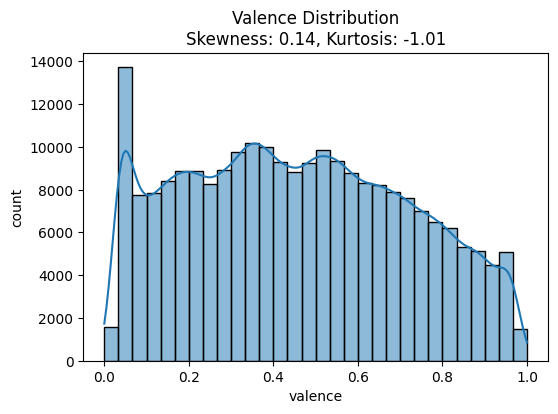

In [41]:
from scipy.stats import skew, kurtosis

# Calculate stats
valence_skew = skew(df['valence'], nan_policy='omit')
valence_kurtosis = kurtosis(df['valence'], nan_policy='omit')

# Plot
plt.figure(figsize=(6, 4))
sns.histplot(df['valence'], kde=True, bins=30)
plt.title(f'Valence Distribution\nSkewness: {valence_skew:.2f}, Kurtosis: {valence_kurtosis:.2f}')
plt.xlabel('valence')
plt.ylabel('count')
plt.show()


The energy distribution is slightly left-skewed, with the highest frequency of values around 10,000 and the lowest around 4,500. The skewness of -0.40 confirms this leftward skew, meaning there are more high-energy values than low-energy values. We also printed the kurtosis value to better understand the shape of the distribution, -0.81. Since it is less than 0 then this means that it has a flatter peak and less outliers (extreme valies) than a normal distribution, making the overall distribution more spread out.

In the context of our model's objective, understanding the distribution of the song's energy is probably a strong predictor for mood since high-energy songs tend to be "happy" while low-energy songs tend to be sad. Results show that most songs in the dataset are moderately to highly energetic, which suggests the model will be trained on a dataset biased toward more upbeat or intense moods. So, we need to keep an eye out to handle this during the training. Despite the imbalance, the feature appears to be useful and unlikely to mislead the model due to noise or outliers.

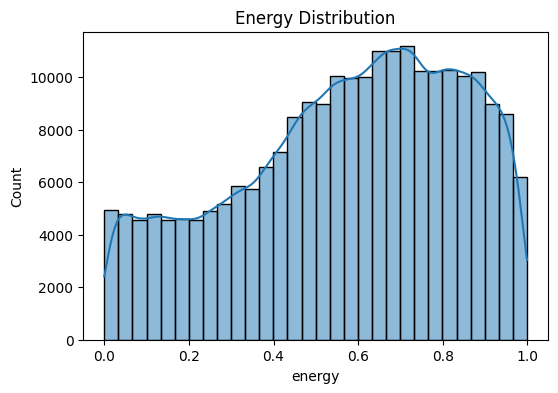

In [42]:
plt.figure(figsize=(6, 4))
sns.histplot(df['energy'], kde=True, bins=30)
plt.title('Energy Distribution')
plt.show()


In [43]:
print("Skewness:", df['energy'].skew())
print("Kurtosis:", df['energy'].kurt())

Skewness: -0.40022327921151274
Kurtosis: -0.8135949529345483


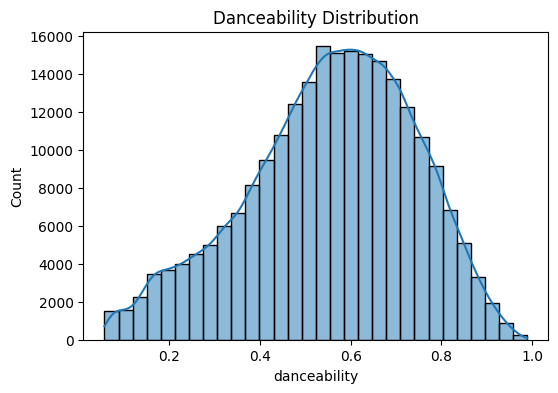

In [44]:
plt.figure(figsize=(6, 4))
sns.histplot(df['danceability'], kde=True, bins=30)
plt.title('Danceability Distribution')
plt.show()


We can see that most songs fall under the extremes with very few in the medium range(0.4-0.6) There is a huge spike on 0.0 meaning that they are likely electronic, synthetic, or heavy produced tracks. There is a smaller spike on 1.0 which means that these are acoustic, live recording etc. 

In what we saw in the stats table above we can see that this makes sense as the mean is 0.368 which means that it goes towards a lower acousticness

We can see that the skewness of the graph being 0.53, which is a positive skew, and it means that most songs have low acoustic content, with a long tail of high acoustic tracks.
The kurtosis being of -1.29 means that values are more evenly spread across the range with fewer extreme outliers

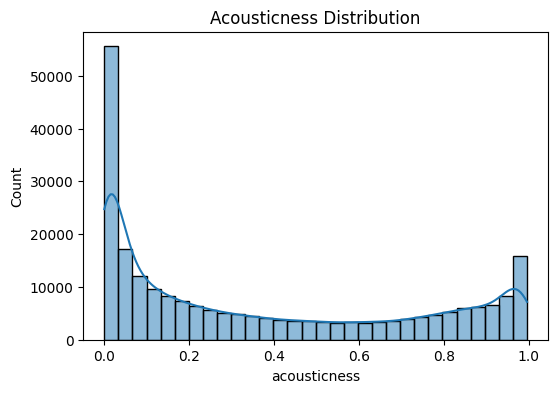

Skewness of acousticness: 0.53
Kurtosis of acousticness: -1.29


In [45]:
from scipy.stats import skew, kurtosis
plt.figure(figsize=(6, 4))
sns.histplot(df['acousticness'], kde=True, bins=30)
plt.title('Acousticness Distribution')
plt.show()

acousticness_data = df['acousticness']

skewness = skew(acousticness_data)
kurt = kurtosis(acousticness_data)

print(f"Skewness of acousticness: {skewness:.2f}")
print(f"Kurtosis of acousticness: {kurt:.2f}")


The distribution of the tempo variable shows that most songs fall between the 90 and 130 bpm range. There's a clear peak around 100-110 bpm, which suggests that there is a presence of mid-tempo tracks maybe more chill and mainstream music. There is also a smaller bump around 120-130 bpm, meaning more energetic genres.

We can also see that tracks under 80 bpm are more uncommon, probably indicating sadder or mellow songs. On the other hand, we see a long tail of faster songs that go past 150 bpm. These might behave differently in mood prediction and could potentially act like outliers.

The skewness value of 0.403 indicates a mild right-skew. This confirms what we've discussed: basically that most songs are in the mid-tempo range, but there is a small group of faster tracks that extend the tail to the right. The kurtosis is -0.467, meaning the distribution is slightly flatter than a normal distribution. Tempo values are more spread out and less sharply peaked, but still fairly balanced and centered around a 90-130 bpm range. 

This plot helps us visualize and confirm what we see in the descriptive stats table above. With tempo values ranging from 30.38 bpm to 242.90 bpm, and having a mean of ~117.7 bpm and a median of ~115.8 BPM, we can assume tempo is slightly right-sweked. The spread, represented by std = 30.9, along with the kurtosis value suggest the dataset includes a good variety or tempo styles without extreme concetration in a specific range.

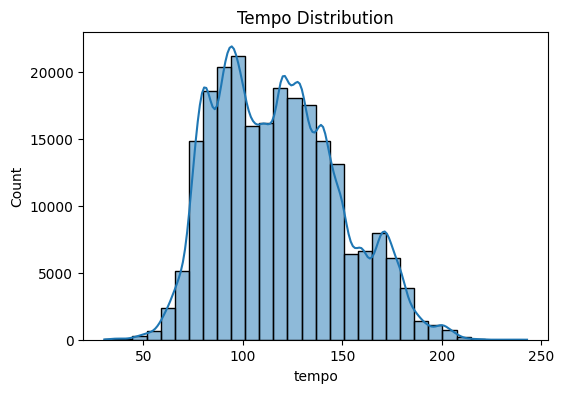

In [46]:
plt.figure(figsize=(6, 4))
sns.histplot(df['tempo'], kde=True, bins=30)
plt.title('Tempo Distribution')
plt.show()


Liveness Distribution

Liveness is measuring the prescence of a live audience or live performance characteristics in a track, going from 0.0 to 1.0.  
The graph shows a strong positive skew since most values have a liveness close to 0, meaning a majority of tracks are studio recorded, not live. This is reinforced with the skewness of 2.07 (which implies a strong positive skew). The kurtosis of 3.89 indicates a high peak around 0.1 and a heavier tail, meaning that few songs deviate strongly from the norm. Since this distribution is highly skewed, using it in the model without any type of scaling or transformation could hurt performance. This is something we will take into account in future steps. From this graph, we can also conclude that liveness is likely not particularly useful when detecting mood since most values are concentrated under 0.3. 

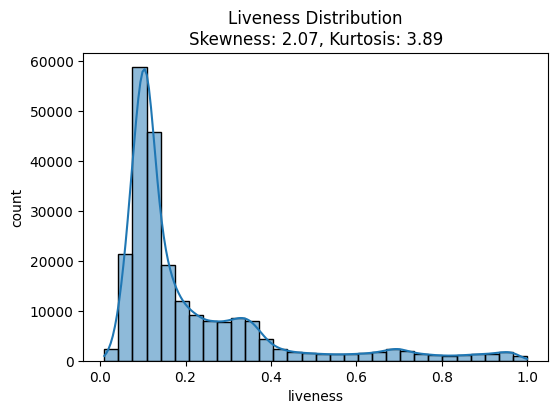

In [47]:
# Calculate skewness and kurtosis for liveness
liveness_skew = skew(df['liveness'], nan_policy='omit')
liveness_kurt = kurtosis(df['liveness'], nan_policy='omit')

# Plot
plt.figure(figsize=(6, 4))
sns.histplot(df['liveness'], kde=True, bins=30)
plt.title(f'Liveness Distribution\nSkewness: {liveness_skew:.2f}, Kurtosis: {liveness_kurt:.2f}')
plt.xlabel('liveness')
plt.ylabel('count')
plt.show()


We can see that higher values indicate more speech-like content (such as podcasts, rap, or voiceovers), and lower values represent typical musical tracks with singing. 

We can see that the graph is highly right-skewed (3.31), with most values being concentrated around 0.0 which means that most of the songs have minimal-speech content. This makes sense since most songs are sung rather than spoken dialogues, which is how spotify actually measures speechiness.

 
The kurtosis of 10.98 means that there is a highly peaked distribution, it means that while most songs cluster around low speechiness, there are notable outliers with significant higher values which likely corresponds to genres with high spoken content such as rap, etc.

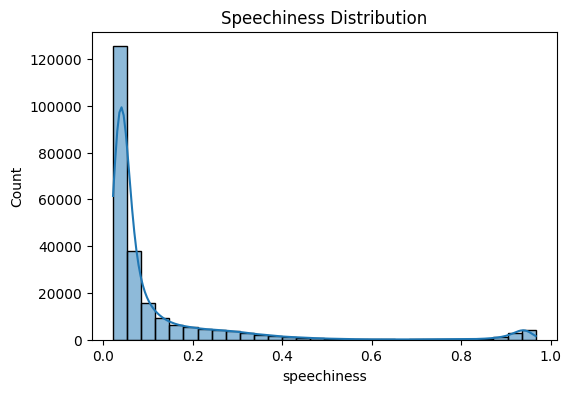

Skewness: 3.31
Kurtosis: 10.98


In [48]:
from scipy.stats import skew, kurtosis
plt.figure(figsize=(6, 4))
sns.histplot(df['speechiness'], kde=True, bins=30)
plt.title('Speechiness Distribution')
plt.show()


speechiness_data = df['speechiness']
print(f"Skewness: {skew(speechiness_data):.2f}")
print(f"Kurtosis: {kurtosis(speechiness_data):.2f}")

Now, to further analyze the relationship between the features, we have decided to print a correlation map since it's the easiest to visualize. If we consider those positive or negatives values greater than 0.6, then the graph shows three strong correlations. 
- **loudness vs acousticness (-0.69)**: This means that as the loudness of a track increases (strong negative correlation), the acousticness tends to decrease, and vice versa. In the context our model, this helps us better understand how "intense" or "natural" a song is. We could potentially remove one to decrease the number of features, but we beleive both are revelant since they describe different things.

- **energy vs acousticness (-0.73)**: This means that as the energy increases the acousticness decreases (strong negative correlation). Which makes sense since high-energy music often involves more synthesized or amplified sounds, whereas acoustic music tends to be calmer, with less energy.  This relationship reinforces the idea that energy could be an important feature for predicting moods like excited, angry, or happy, while acousticness might be more relevant for moods like calm or sad. Additionally, this is similar to the previous relationship, where we are not sure we should remove one or the other becuase both feature describe different things and can help predict different moods that are similar to just "happy" or "sad".

- **energy vs loudness (0.82)**: This means that as energy increases, so does the loudness (strong postive correlation). This is expected, as more intense and energetic music often has higher volumes and more dynamic sound. Since these features are more related to each other in terms of what they describe, typically upbeat, excited, or happy moods, maybe it we could drop one. 

The distribution of the instrumentalness feature is heavily right-skewed. It has a significant peak near 0, which indicates that most tracks in the dataset have vocals. There is also a very small cluster of tracks with instrumentalness close to 1.0. These represent instrumental-only songs. These take up a small portion of the dataset, but they're still important because they may behave differently in mood modeling.

The instrumentalness distribution shows a strong right-skew, confirmed by a skewness of 1.820, meaning most tracks have very low instrumentalness.

The kurtosis is 1.588, indicating a distribution that is more peaked than normal, with heavy tails. This means while most songs cluster near zero, there’s a distinct minority of fully instrumental tracks that stand out at the upper end of the scale.

Lastly, the instrumentalness feature has a mean of ~0.15 and a median of 0.0, indicating that over half the tracks have no instrumental quality, in other words they contain vocals. The minimum, 25th, and 50th percentiles are all exactly 0.0, which show that the majority of tracks fall at the very bottom of the scale. However, the maximum value reaches 0.999, showing that some tracks are fully instrumental.

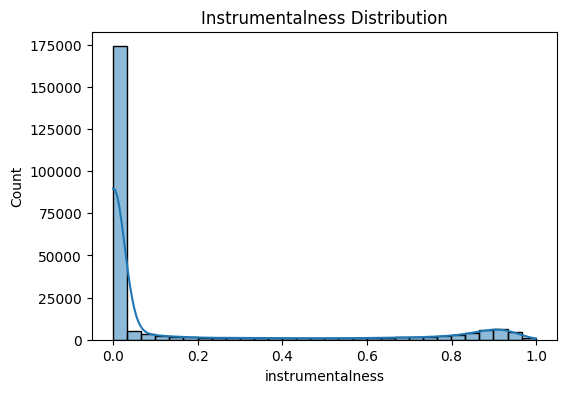

Instrumentalness Skewness: 1.820
Instrumentalness Kurtosis: 1.588


In [49]:
plt.figure(figsize=(6, 4))
sns.histplot(df['instrumentalness'], kde=True, bins=30)
plt.title('Instrumentalness Distribution')
plt.show()

inst_data = df['instrumentalness'].dropna()

inst_skew = skew(inst_data)
inst_kurt = kurtosis(inst_data)  # Fisher's definition: normal = 0

print(f"Instrumentalness Skewness: {inst_skew:.3f}")
print(f"Instrumentalness Kurtosis: {inst_kurt:.3f}")

The loudness feature in the dataset has values ranging from -52.46 dB to 3.74 dB, with a mean of -9.57 dB and a median of -7.76 dB. This means most tracks are fairly loud, represented by those close to 0 dB, while only a small minority are significantly quieter.

The distribution is left-skewed, the skewness being -1.662, which is clearly visible in the histogram. There’s a long tail of very quiet tracks pulling the distribution to the left.

The kurtosis is 3.207, indicating that the distribution is sharply peaked with heavy tails. This suggests that most tracks are clustered tightly around typical loudness values ( -10 to -5 dB), but there are outliers at both extremes (super loud and super soft).

To conclude, this means loudness is a solid feature for modeling the intensity of a track. Louder songs may correlate with high-energy or party moods, while quieter tracks could lean more toward chill, acoustic, or emotional vibes. This will all help in mood predicting.

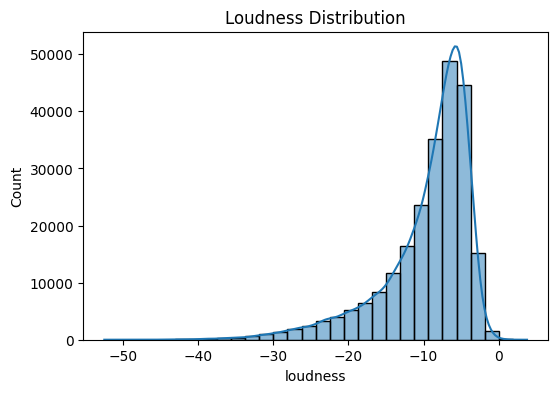

Loudness Skewness: -1.662
Loudness Kurtosis: 3.207


In [50]:
plt.figure(figsize=(6, 4))
sns.histplot(df['loudness'], kde=True, bins=30)
plt.title('Loudness Distribution')
plt.show()

loud_data = df['loudness'].dropna()

loud_skew = skew(loud_data)
loud_kurt = kurtosis(loud_data)  # Fisher's definition: normal = 0

print(f"Loudness Skewness: {loud_skew:.3f}")
print(f"Loudness Kurtosis: {loud_kurt:.3f}")

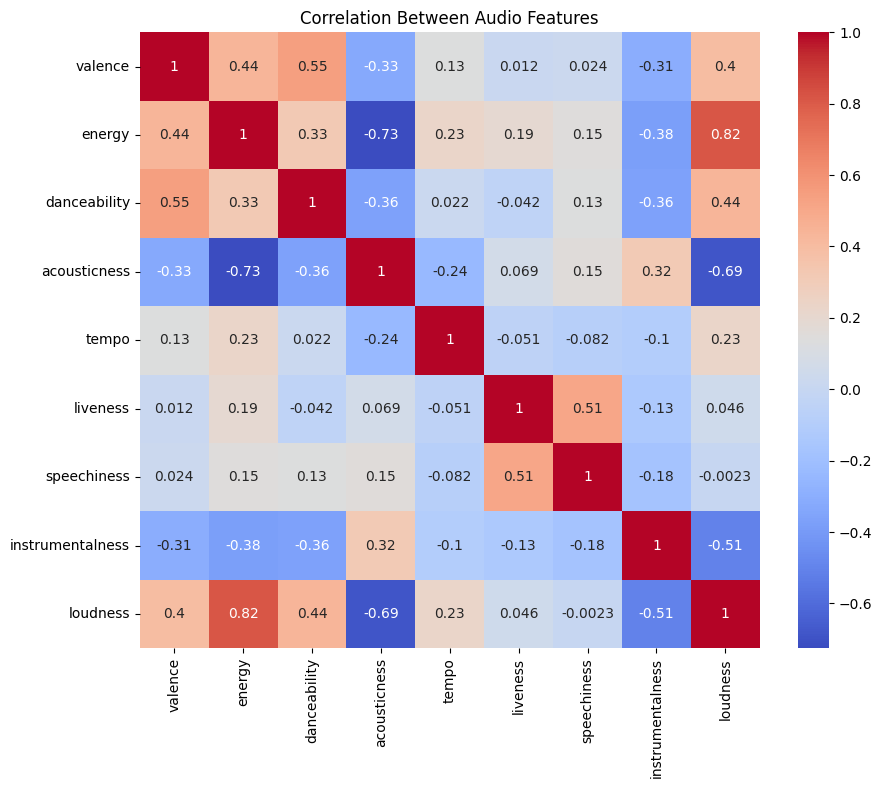

In [51]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[audio_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Audio Features')
plt.show()


The first bar plot shows the top genres in the dataset, with each bar representing the number of tracks per genre. We can see that within these genres, there are roughly an equal amount of songs (nearly 1000)


The valence feature captures the musical positivity or emotional brightness of a song, where values closer to 1.0 indicate a happy, cheerful, or euphoric tone, and values near 0.0 suggest sadness, melancholy, or tension.

Analyzing valence across all genres in the dataset reveals distinct emotional profiles:
- Genres such as Pop, Reggae, Ska, Jazz, and Comedy show high median valence, indicating that these styles tend to produce more uplifting or feel-good tracks, consistent with their energetic or playful musical characteristics.

- Hip-Hop, Dance, Country, and Electronic display moderate valence levels, reflecting a mix of emotional tones depending on lyrical content and production style.

- On the lower end, Soundtrack, Opera, and Classical genres have notably lower median valence, with many tracks clustering near 0.2 or below. This suggests these genres are often composed to evoke more emotional depth, tension, or introspection.

- Interestingly, Children’s Music shows a bimodal distribution, with both very high and very low valence songs, likely due to its diversity between upbeat singalongs and calm lullabies.

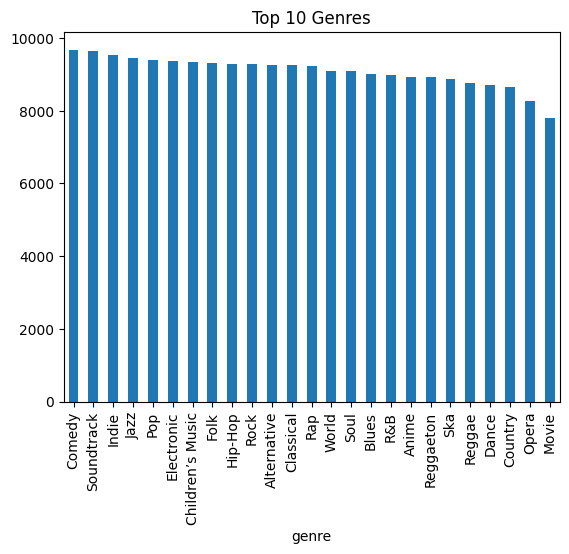

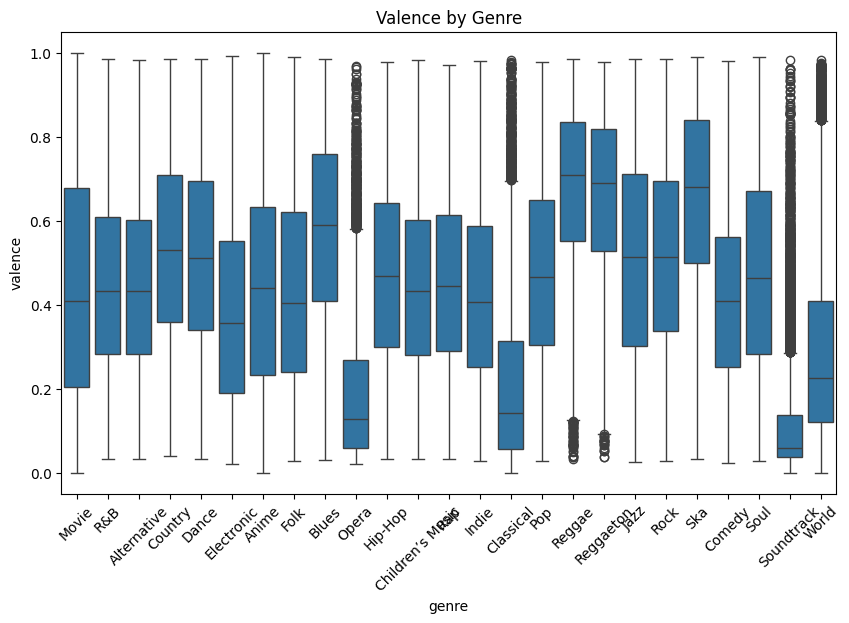

In [52]:
df['genre'].value_counts().head(25).plot(kind='bar')
plt.title('Top 10 Genres')
plt.show()

# Boxplots of valence by genre
top_genres = df['genre'].value_counts().head(25).index
subset = df[df['genre'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='genre', y='valence', data=subset)
plt.title('Valence by Genre')
plt.xticks(rotation=45)
plt.show()

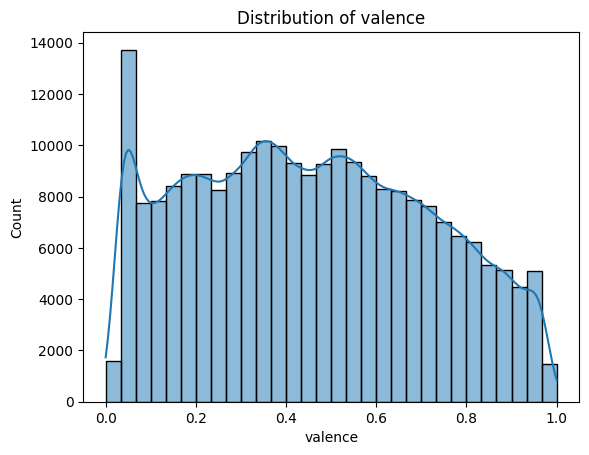

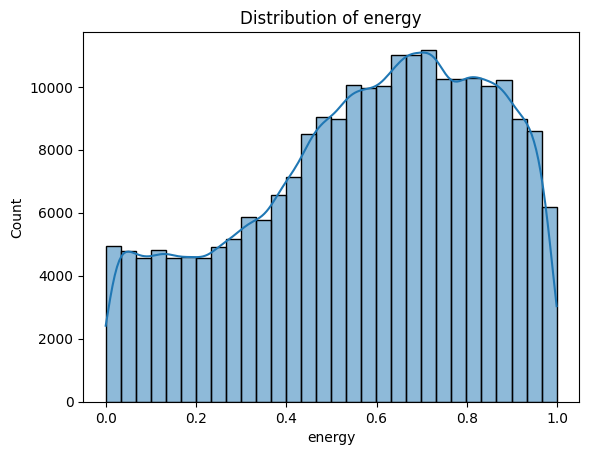

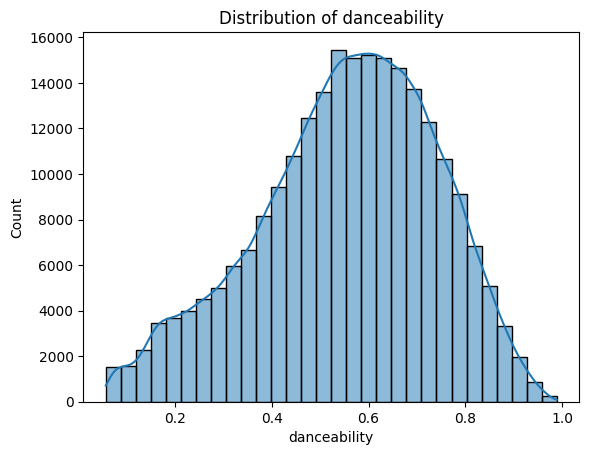

In [53]:
for feature in ['valence', 'energy', 'danceability']:
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

# <font color='#3c3c3c'>EDA-2</font>

In [54]:
features = ['valence', 'energy', 'danceability', 'acousticness', 'tempo', 'loudness', 
    'speechiness', 
    'instrumentalness', 
    'liveness']

X = df[features]

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [56]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
df['mood_cluster'] = kmeans.fit_predict(X_scaled)

In [57]:
cluster_summary = df.groupby('mood_cluster')[features].mean()
print(cluster_summary)

               valence    energy  danceability  acousticness       tempo  \
mood_cluster                                                               
0             0.336002  0.332763      0.506147      0.697375  111.752528   
1             0.640722  0.670030      0.704638      0.192694  108.926153   
2             0.155164  0.165379      0.292362      0.844025  102.478091   
3             0.414632  0.663503      0.562818      0.789351   98.023968   
4             0.430969  0.766319      0.503566      0.099973  142.572296   

               loudness  speechiness  instrumentalness  liveness  
mood_cluster                                                      
0            -12.008261     0.065861          0.066356  0.178686  
1             -7.041822     0.104922          0.059300  0.172583  
2            -20.922792     0.045696          0.740426  0.146678  
3            -11.988400     0.877456          0.001191  0.729090  
4             -5.947786     0.093683          0.091934  0.244200 

In [58]:
cluster_to_mood = {
    0: 'Mellow',
    1: 'Happy Party',
    2: 'Sad Acoustic',
    3: 'Chill Vibes',
    4: 'Energetic'
}

df['mood'] = df['mood_cluster'].map(cluster_to_mood)

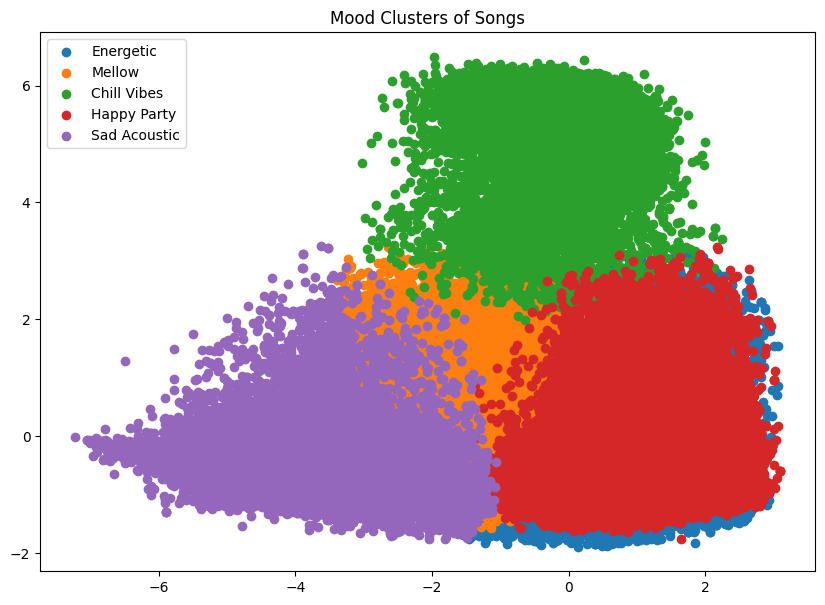

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df['pca1'] = components[:, 0]
df['pca2'] = components[:, 1]

plt.figure(figsize=(10,7))
for mood in df['mood'].unique():
    subset = df[df['mood'] == mood]
    plt.scatter(subset['pca1'], subset['pca2'], label=mood)
    
plt.legend()
plt.title('Mood Clusters of Songs')
plt.show()

In [60]:
cluster_summary = df.groupby('mood_cluster')[[
    'valence', 'energy', 'danceability', 'acousticness', 
    'tempo', 'loudness', 'speechiness', 'instrumentalness', 'liveness'
]].mean().round(2)

print(cluster_summary)

              valence  energy  danceability  acousticness   tempo  loudness  \
mood_cluster                                                                  
0                0.34    0.33          0.51          0.70  111.75    -12.01   
1                0.64    0.67          0.70          0.19  108.93     -7.04   
2                0.16    0.17          0.29          0.84  102.48    -20.92   
3                0.41    0.66          0.56          0.79   98.02    -11.99   
4                0.43    0.77          0.50          0.10  142.57     -5.95   

              speechiness  instrumentalness  liveness  
mood_cluster                                           
0                    0.07              0.07      0.18  
1                    0.10              0.06      0.17  
2                    0.05              0.74      0.15  
3                    0.88              0.00      0.73  
4                    0.09              0.09      0.24  


# <font color='#3c3c3c'>Handling Missing values</font>

One row in the dataset contained a missing value (track name) and was dropped during preprocessing. Given the dataset’s large size, this removal will have no impact on the analysis or model performance

In [61]:
df.dropna(inplace=True)

# <font color='#3c3c3c'>Data Splitting</font>

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X = df.select_dtypes(include='number').drop(columns=['mood'], errors='ignore')
y = df['mood'] 

# First split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)  # 0.25 of 80% = 20% total

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (139634, 14)
Validation: (46545, 14)
Test: (46545, 14)


# <font color='#3c3c3c'>Data Imputation</font>

# <font color='#3c3c3c'>Creating New Features</font>

In [64]:
drop_cols = [
    'track_name',      
    'track_id',        
    'artist_name',     
    'genre',            
    'duration_ms',
    'popularity'   
]

# <font color='#3c3c3c'>Encoding Categorical Variables</font>

In [65]:
df = pd.get_dummies(df, columns=['key', 'time_signature'], drop_first=True)

In [66]:
print(df.columns)

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'valence', 'mood_cluster', 'mood', 'pca1', 'pca2', 'key_A#',
       'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F',
       'key_F#', 'key_G', 'key_G#', 'time_signature_1/4', 'time_signature_3/4',
       'time_signature_4/4', 'time_signature_5/4'],
      dtype='object')


# <font color='#3c3c3c'>Feature Scaling</font>

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Then transform val and test with the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

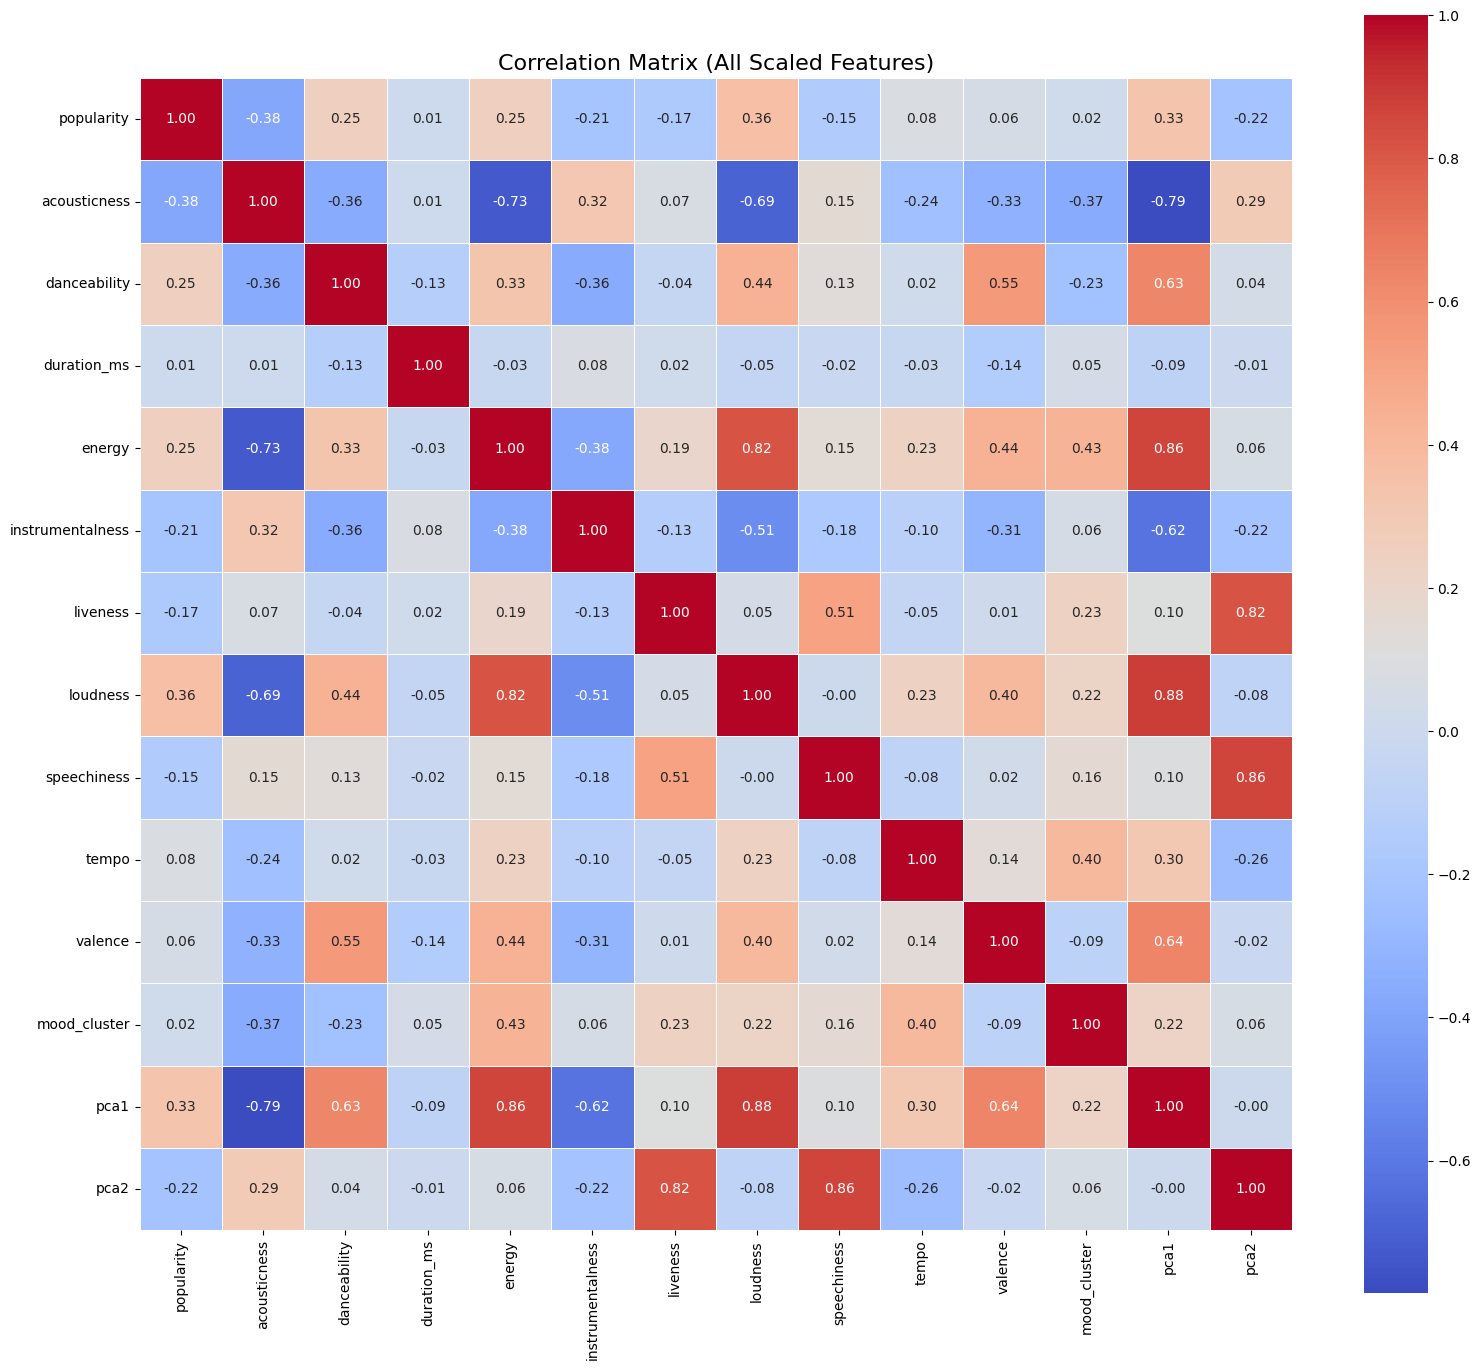

In [68]:
column_names = X.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)

corr_matrix = X_train_scaled_df.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix (All Scaled Features)", fontsize=16)
plt.tight_layout()
plt.show()

# <font color='#3c3c3c'>Adressing Class Imbalance</font>

# <font color='#3c3c3c'>Feature Selection</font>

# <font color='#3c3c3c'>Baseline</font>